<a href="https://colab.research.google.com/github/skhazaei/TensorFlow-repo/blob/master/sarcasm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the sarcasm dataset

In [4]:
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
-O /tmp/sarcasm.json

--2021-02-16 18:18:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-02-16 18:18:51 (284 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



## Load the dataset, then read the headlines and labels

In [8]:
import json

with open('/tmp/sarcasm.json', 'r') as f:
  datastore=json.load(f)

headlines=[]
labels=[]

for item in datastore:
  headlines.append(item['headline'])
  labels.append(item['is_sarcastic'])

## Split the corpus to the training and validation sets

Set training_size to 20,000 

In [11]:
print('The size of sarcasm dataset: ', len(datastore))

The size of sarcasm dataset:  26709


In [13]:
training_size = 20000

training_headlines = headlines[0:training_size]
training_labels = labels[0:training_size]

test_headlines = headlines[training_size:]
test_labels = labels[training_size:]

## Tokenize the headlines

In [40]:
# hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_headlines)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_headlines)
padded = pad_sequences(sequences, padding=padding_type,
                       truncating=trunc_type, maxlen=max_length)

test_seq = tokenizer.texts_to_sequences(test_headlines)
test_padded = pad_sequences(test_seq, padding=padding_type,
                            truncating=trunc_type, maxlen=max_length)

In [42]:
import numpy as np

## Convert the lists to the numpy array
padded = np.array(padded)
training_labels = np.array(training_labels)
test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

## Define the neural network model

In [43]:
import tensorflow as tf
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                    tf.keras.layers.GlobalAveragePooling1D(),
                                    tf.keras.layers.Dense(24, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
num_epochs = 30

history = model.fit(padded, training_labels,
                    validation_data=(test_padded, test_labels),
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.5558 - accuracy: 0.7182 - val_loss: 0.3917 - val_accuracy: 0.8374
Epoch 2/30
625/625 - 2s - loss: 0.3096 - accuracy: 0.8756 - val_loss: 0.3411 - val_accuracy: 0.8575
Epoch 3/30
625/625 - 1s - loss: 0.2324 - accuracy: 0.9075 - val_loss: 0.3524 - val_accuracy: 0.8524
Epoch 4/30
625/625 - 1s - loss: 0.1884 - accuracy: 0.9273 - val_loss: 0.3759 - val_accuracy: 0.8433
Epoch 5/30
625/625 - 2s - loss: 0.1559 - accuracy: 0.9412 - val_loss: 0.3875 - val_accuracy: 0.8529
Epoch 6/30
625/625 - 1s - loss: 0.1312 - accuracy: 0.9532 - val_loss: 0.4177 - val_accuracy: 0.8484
Epoch 7/30
625/625 - 1s - loss: 0.1116 - accuracy: 0.9622 - val_loss: 0.4581 - val_accuracy: 0.8436
Epoch 8/30
625/625 - 1s - loss: 0.0961 - accuracy: 0.9681 - val_loss: 0.4993 - val_accuracy: 0.8407
Epoch 9/30
625/625 - 1s - loss: 0.0831 - accuracy: 0.9725 - val_loss: 0.5467 - val_accuracy: 0.8348
Epoch 10/30
625/625 - 1s - loss: 0.0717 - accuracy: 0.9774 - val_loss: 0.5923 - val_accuracy: 0.8340

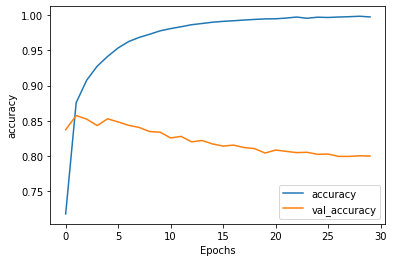

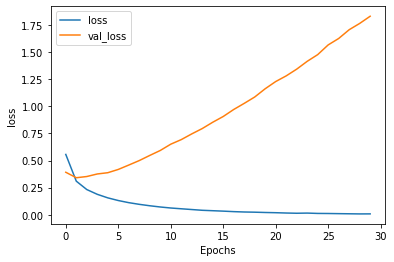

In [47]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

It can be seen the accuracy increase nicely as we trained and the validation accuracy was okay, but not great. What's interesting is the loss values, the training loss fall, but the validation loss increased. 

Loss in this context is can be considered as a confidence in the prediction. So while the number of accurate predictions increased over time, what was interesting was that the confidence per prediction effectively decreased. This migh happen a lot with text data. So it's very important to keep an eye on it. One way to do this is to explore the differences as you tweak the hyperparameters. 

Epoch 1/30
625/625 - 1s - loss: 0.5275 - accuracy: 0.7308 - val_loss: 0.4134 - val_accuracy: 0.8114
Epoch 2/30
625/625 - 1s - loss: 0.3805 - accuracy: 0.8271 - val_loss: 0.3990 - val_accuracy: 0.8135
Epoch 3/30
625/625 - 1s - loss: 0.3630 - accuracy: 0.8355 - val_loss: 0.4000 - val_accuracy: 0.8106
Epoch 4/30
625/625 - 1s - loss: 0.3584 - accuracy: 0.8350 - val_loss: 0.4016 - val_accuracy: 0.8152
Epoch 5/30
625/625 - 1s - loss: 0.3548 - accuracy: 0.8395 - val_loss: 0.4055 - val_accuracy: 0.8095
Epoch 6/30
625/625 - 1s - loss: 0.3531 - accuracy: 0.8412 - val_loss: 0.4034 - val_accuracy: 0.8146
Epoch 7/30
625/625 - 1s - loss: 0.3504 - accuracy: 0.8400 - val_loss: 0.4049 - val_accuracy: 0.8150
Epoch 8/30
625/625 - 1s - loss: 0.3475 - accuracy: 0.8416 - val_loss: 0.4002 - val_accuracy: 0.8143
Epoch 9/30
625/625 - 1s - loss: 0.3426 - accuracy: 0.8443 - val_loss: 0.3980 - val_accuracy: 0.8137
Epoch 10/30
625/625 - 1s - loss: 0.3386 - accuracy: 0.8467 - val_loss: 0.4002 - val_accuracy: 0.8146

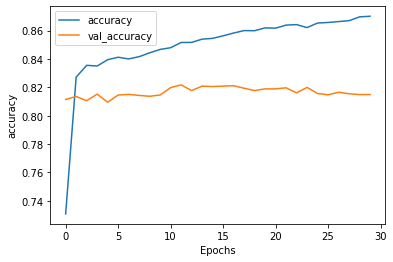

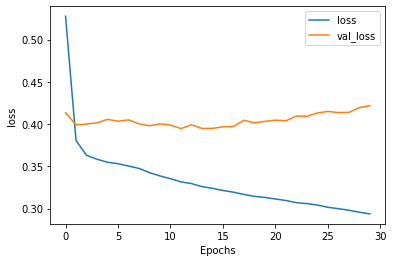

In [49]:
# hyperparameters
vocab_size = 1000   #this value was set to 10000
embedding_dim = 16  
max_length = 16 #this value was set to 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000



from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_headlines)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_headlines)
padded = pad_sequences(sequences, padding=padding_type,
                       truncating=trunc_type, maxlen=max_length)

test_seq = tokenizer.texts_to_sequences(test_headlines)
test_padded = pad_sequences(test_seq, padding=padding_type,
                            truncating=trunc_type, maxlen=max_length)



import numpy as np

## Convert the lists to the numpy array
padded = np.array(padded)
training_labels = np.array(training_labels)
test_padded = np.array(test_padded)
test_labels = np.array(test_labels)



import tensorflow as tf
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                    tf.keras.layers.GlobalAveragePooling1D(),
                                    tf.keras.layers.Dense(24, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])


num_epochs = 30

history = model.fit(padded, training_labels,
                    validation_data=(test_padded, test_labels),
                    epochs=num_epochs,
                    verbose=2)



import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Epoch 1/30
625/625 - 1s - loss: 0.4983 - accuracy: 0.7502 - val_loss: 0.4045 - val_accuracy: 0.8135
Epoch 2/30
625/625 - 1s - loss: 0.3758 - accuracy: 0.8292 - val_loss: 0.3985 - val_accuracy: 0.8162
Epoch 3/30
625/625 - 1s - loss: 0.3633 - accuracy: 0.8352 - val_loss: 0.4024 - val_accuracy: 0.8135
Epoch 4/30
625/625 - 1s - loss: 0.3585 - accuracy: 0.8362 - val_loss: 0.4025 - val_accuracy: 0.8138
Epoch 5/30
625/625 - 1s - loss: 0.3568 - accuracy: 0.8376 - val_loss: 0.4041 - val_accuracy: 0.8141
Epoch 6/30
625/625 - 1s - loss: 0.3551 - accuracy: 0.8377 - val_loss: 0.4033 - val_accuracy: 0.8089
Epoch 7/30
625/625 - 1s - loss: 0.3529 - accuracy: 0.8389 - val_loss: 0.4065 - val_accuracy: 0.8085
Epoch 8/30
625/625 - 1s - loss: 0.3501 - accuracy: 0.8397 - val_loss: 0.4006 - val_accuracy: 0.8132
Epoch 9/30
625/625 - 1s - loss: 0.3472 - accuracy: 0.8425 - val_loss: 0.3992 - val_accuracy: 0.8174
Epoch 10/30
625/625 - 1s - loss: 0.3433 - accuracy: 0.8420 - val_loss: 0.4017 - val_accuracy: 0.8131

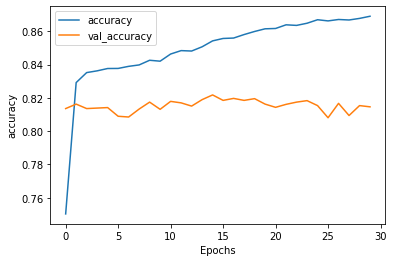

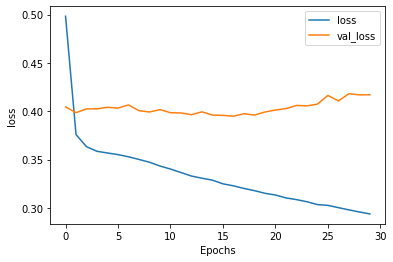

In [50]:
# hyperparameters
vocab_size = 1000   #this value was set to 10000
embedding_dim = 32  #this value was set to 16
max_length = 16 #this value was set to 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000



from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_headlines)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_headlines)
padded = pad_sequences(sequences, padding=padding_type,
                       truncating=trunc_type, maxlen=max_length)

test_seq = tokenizer.texts_to_sequences(test_headlines)
test_padded = pad_sequences(test_seq, padding=padding_type,
                            truncating=trunc_type, maxlen=max_length)



import numpy as np

## Convert the lists to the numpy array
padded = np.array(padded)
training_labels = np.array(training_labels)
test_padded = np.array(test_padded)
test_labels = np.array(test_labels)



import tensorflow as tf
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                    tf.keras.layers.GlobalAveragePooling1D(),
                                    tf.keras.layers.Dense(24, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])


num_epochs = 30

history = model.fit(padded, training_labels,
                    validation_data=(test_padded, test_labels),
                    epochs=num_epochs,
                    verbose=2)



import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [51]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.45638537]
 [0.5631679 ]]
